# Libs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Pre-task execution

In [2]:
filename = 'IT_Salary_Survey_EU _2020.csv'

df = pd.read_csv(filename, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 22 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1226 non-null   float64
 1   Gender                                                                                                                   1243 non-null   object 
 2   City                                                                                                                     1253 non-null   object 
 3   Position                                                                                                      

## Data clearing

### Age

In [3]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Age'] = df['Age'].fillna(df['Age'].median())

### Total years of experience

In [4]:
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'], errors='coerce')
df['Total years of experience'] = df['Total years of experience'].fillna(df['Total years of experience'].median())
df = df[df['Total years of experience'] < 70]

### Yeart of experince in Germany

In [5]:
df['Years of experience in Germany'] = pd.to_numeric(df['Years of experience in Germany'], errors='coerce')
df['Years of experience in Germany'] = df['Years of experience in Germany'].fillna(df['Years of experience in Germany'].median())

### Yearly bonus

In [6]:
df['Yearly bonus + stocks in EUR'] = pd.to_numeric(df['Yearly bonus + stocks in EUR'], errors='coerce')
df['Yearly bonus + stocks in EUR'] = df['Yearly bonus + stocks in EUR'].fillna(0)

### Annual bonus

In [7]:
del df['Annual bonus+stocks one year ago. Only answer if staying in same country']

### Brutto salary

In [8]:
df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'] = df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'].fillna(df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'].median())

### Number of vacation

In [9]:
df['Number of vacation days'] = pd.to_numeric(df['Number of vacation days'], errors='coerce')
df['Number of vacation days'] = df['Number of vacation days'].fillna(df['Number of vacation days'].median())

### Monetary support

In [10]:
df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'] = pd.to_numeric(df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'], errors='coerce')
df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'] = df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'].fillna(0)

### Shorter work week

In [11]:
df['Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week'] = df['Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week'].fillna(0)

## Results

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 21 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1252 non-null   float64
 1   Gender                                                                                                                   1242 non-null   object 
 2   City                                                                                                                     1252 non-null   object 
 3   Position                                                                                                      

## Dummy files

- Work time is not representative (most values are full-time and usual logic can say that it's not usefull to compare full-time and part-time salaries)
- Positions are lots of values (a lot of them are 1 row in the dataset, can be a lot of wrong data)
- Technologies are particular the same and contain a lot of different data (React + TypeScript and JavaScript + TypeScript. We don't know the correct splitting that two rows).

In [13]:
df.loc[df.groupby('Seniority level')['Seniority level'].transform('count').lt(4), 'Seniority level'] = 'other'
df.loc[df.groupby('Сontract duration')['Сontract duration'].transform('count').lt(4), 'Сontract duration'] = 'other'
df.loc[df.groupby('Main language at work')['Main language at work'].transform('count').lt(4), 'Main language at work'] = 'other'
df.loc[df.groupby('Company type')['Company type'].transform('count').lt(4), 'Company type'] = 'other'
df.loc[df.groupby('Have you lost your job due to the coronavirus outbreak?')['Have you lost your job due to the coronavirus outbreak?'].transform('count').lt(4), 'Have you lost your job due to the coronavirus outbreak?'] = 'other'

In [14]:
df_with_dummies = pd.get_dummies(df, columns=['Gender'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Seniority level'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Сontract duration'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Main language at work'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Company size'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Company type'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Have you lost your job due to the coronavirus outbreak?'])

# Choose predicted variable

In [15]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 43 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1252 non-null   float64
 1   City                                                                                                                     1252 non-null   object 
 2   Position                                                                                                                 1246 non-null   object 
 3   Total years of experience                                                                                     

Dependent variable is **"Yearly brutto salary (without bonus and stocks) in EUR"**. Let's rename it for more comfortable

In [19]:
df_with_dummies = df_with_dummies.rename(columns={"Yearly brutto salary (without bonus and stocks) in EUR": "Salary"})
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 43 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1252 non-null   float64
 1   City                                                                                                                     1252 non-null   object 
 2   Position                                                                                                                 1246 non-null   object 
 3   Total years of experience                                                                                     

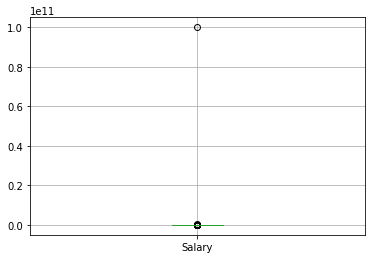

In [20]:
df_with_dummies.boxplot(column='Salary')

Let's clear strange data

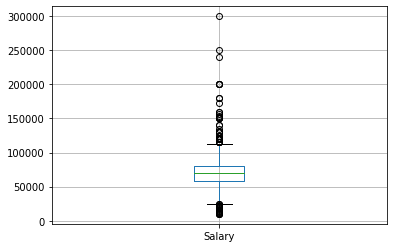

In [22]:
df_with_dummies = df_with_dummies[df_with_dummies['Salary'] < 600000]
df_with_dummies.boxplot(column='Salary')

In [23]:
df_with_dummies['Salary'].describe()

count      1249.000000
mean      71033.108191
std       24350.406641
min       10001.000000
25%       58000.000000
50%       70000.000000
75%       80000.000000
max      300000.000000
Name: Salary, dtype: float64

# Hypothesis

H1: The distribution of the variable 'Salary' is different from the normal distribution

H0: The distribution of the variable 'Salary' is not different from the normal distribution

p-value = 0.05

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


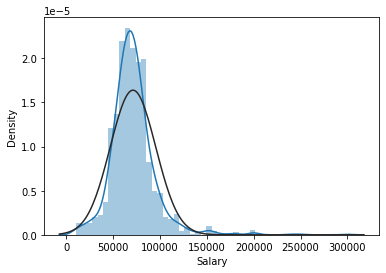

In [24]:
sns.distplot(df_with_dummies['Salary'], fit=stats.norm)

In [27]:
stats.kstest(
    df_with_dummies['Salary'], 
    'norm', 
    args=(
        df_with_dummies['Salary'].mean(), 
        df_with_dummies['Salary'].std()
    )
)

KstestResult(statistic=0.12816309604155152, pvalue=2.407220888550315e-18)

In [28]:
print('Skewness: {:.4f}'.format(df_with_dummies['Salary'].skew()))
print('Kurtosis: {:.4f}'.format(df_with_dummies['Salary'].kurt()))
print('Quartile Deviation: {:.4f}'.format((df_with_dummies['Salary'].quantile(0.75) - df_with_dummies['Salary'].quantile(0.25))/2))
print('Decile Ratio: {:.4f}'.format(df_with_dummies['Salary'].quantile(0.9)/df_with_dummies['Salary'].quantile(0.1)))

Skewness: 2.1964
Kurtosis: 13.5674
Quartile Deviation: 11000.0000
Decile Ratio: 1.9792


The dependent variable 'Yearly brutto salary (without bonus and stocks) in EUR' deviates from the normal distribution (H1 is accepted at p-value = 0.05). It has a highly skewed leptokurtic distribution with positive skewness.

# Predictors

In [29]:
df_with_dummies.corrwith(df_with_dummies['Salary']).sort_values(ascending=False)

Salary                                                                                                                     1.000000
Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country                   0.488552
Total years of experience                                                                                                  0.357453
Seniority level_Lead                                                                                                       0.284528
Yearly bonus + stocks in EUR                                                                                               0.269721
Years of experience in Germany                                                                                             0.266610
Seniority level_Head                                                                                                       0.236170
Age                                                                         

Variables which have not very weak correlation with the dependent variable, which can become predictors:

- Annual brutto salary (without bonus and stocks) one year ago.
- Total years of experience
- Yearly bonus + stocks in EUR
- Years of experience in Germany
- Seniority level (cat.)
- Age
- Gender (cat.)

## Predictors Analysis (pairwised)

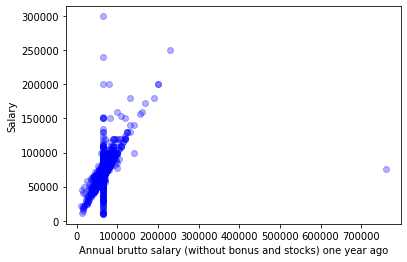

In [30]:
plt.scatter(df_with_dummies['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'], df_with_dummies['Salary'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Annual brutto salary (without bonus and stocks) one year ago')
plt.ylabel('Salary')
plt.show()

There is a positive linear relationship.

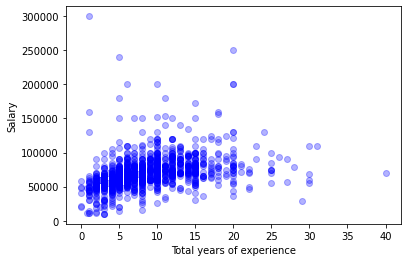

In [32]:
plt.scatter(df_with_dummies['Total years of experience'], df_with_dummies['Salary'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Total years of experience')
plt.ylabel('Salary')
plt.show()

There is a positive linear relationship.

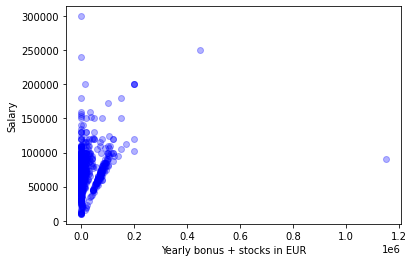

In [33]:
plt.scatter(df_with_dummies['Yearly bonus + stocks in EUR'], df_with_dummies['Salary'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Yearly bonus + stocks in EUR')
plt.ylabel('Salary')
plt.show()

There is a positive linear relationship.

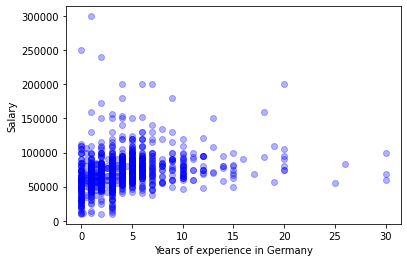

In [34]:
plt.scatter(df_with_dummies['Years of experience in Germany'], df_with_dummies['Salary'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Years of experience in Germany')
plt.ylabel('Salary')
plt.show()

There is a positive linear relationship.

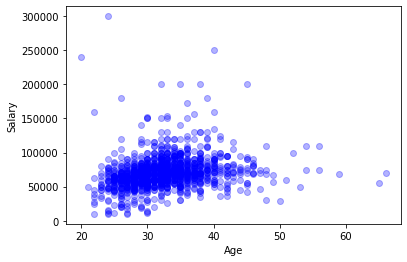

In [35]:
plt.scatter(df_with_dummies['Age'], df_with_dummies['Salary'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

There is a positive linear relationship.

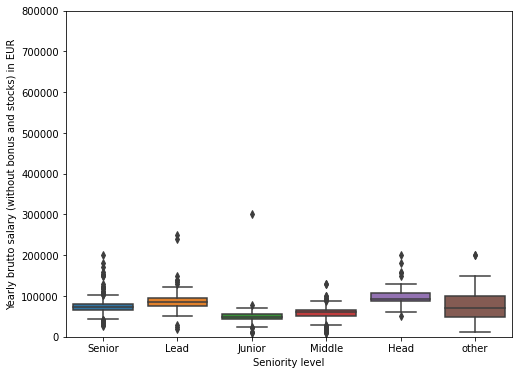

In [36]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Seniority level'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Seniority level']], axis=1))
fig.axis(ymin=0, ymax=800000)
plt.show()

There is a positive linear relationship.

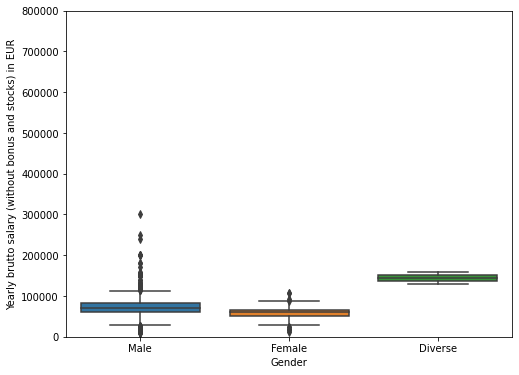

In [37]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Gender'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Gender']], axis=1))
fig.axis(ymin=0, ymax=800000)
plt.show()

There is a positive linear relationship.

# Linear regression

#### Hypothesis:

H0: The linear regression model constructed for a dependent variable 'Salary' and the following predictors:
- Annual brutto salary (without bonus and stocks) one year ago.
- Total years of experience
- Yearly bonus + stocks in EUR
- Years of experience in Germany
- Seniority level (cat.)
- Age
- Gender (cat.)

explains the variation of 'Salary'.

H1: The aforementioned model does not explain the variation of 'Salary'.

p-value = 0.05.

The hypothesis can be checked based on R^2 of the model as well as based on the results of F-test

In [38]:
predictors = [
    "Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country",
    "Total years of experience",
    "Yearly bonus + stocks in EUR",
    "Years of experience in Germany",
    'Seniority level_Head',
    'Seniority level_Junior',
    'Seniority level_Lead',
    'Seniority level_Middle',
    'Seniority level_Senior', 
    'Seniority level_other',
    'Age',
    'Gender_Diverse',
    'Gender_Male',
    'Gender_Female'
]

In [39]:
import statsmodels.api as sm
df_model = df_with_dummies.dropna(subset=predictors)
df_model.shape

(1249, 43)

In [40]:
x_mult = df_model[predictors]
y = df_model['Salary']
x_mult_constant = sm.add_constant(x_mult)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
model = sm.OLS(y, x_mult_constant).fit()

In [42]:
print('R^2 = {:f}'.format(model.rsquared))
print('F-test significance = {:f}'.format(model.f_pvalue))

R^2 = 0.438155
F-test significance = 0.000000


#### Conclusion:

The model is statistically significant and explains 44% of variance of variable 'Salarey'. H1 is rejected at p-value = 0.05

# Model characteristics

#### Hypothesis:

H0: The following variables:
- Annual brutto salary (without bonus and stocks) one year ago.
- Total years of experience
- Yearly bonus + stocks in EUR
- Years of experience in Germany
- Seniority level (cat.)
- Age
- Gender (cat.)

are statistically significant for the linear regression model constructed for a dependent variable 'Salary'.

H1: The aforementioned variables are not statistically significant for the linear regression model constructed for a dependent variable 'Salary'.

p-value = 0.05

The hypothesis can be checked by estimating p-values of each variable in the constructed model

In [43]:
print(f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}')

Statistically significant model parameters: ['const'
 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'
 'Total years of experience' 'Yearly bonus + stocks in EUR'
 'Years of experience in Germany' 'Seniority level_Head'
 'Seniority level_Junior' 'Age' 'Gender_Diverse']


In [44]:
print(f'Statistically nonsignificant model parameters: {model.pvalues[model.pvalues > 0.05].index.values}')

Statistically nonsignificant model parameters: ['Seniority level_Lead' 'Seniority level_Middle' 'Seniority level_Senior'
 'Seniority level_other' 'Gender_Male' 'Gender_Female']


#### Conclusion:

At p-value = 0.05 the following predictors are statistically signficant (so H1 is rejected):

- 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'
- 'Total years of experience' 
- 'Yearly bonus + stocks in EUR'
- 'Years of experience in Germany' 
- 'Seniority level_Head'
- 'Seniority level_Junior' 
- 'Age' 
- 'Gender_Diverse'

The following predictors are not statistically significant (so H1 is accepted):

- 'Seniority level_Lead' 
- 'Seniority level_Middle' 
- 'Seniority level_Senior'
- 'Seniority level_other' 
- 'Gender_Male' 
- 'Gender_Female'

#### Regression equation

In [45]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))
    
print('Y = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

Y = 59432.823510 + 0.30*Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country + 642.42*Total years of experience + 0.09*Yearly bonus + stocks in EUR + 598.40*Years of experience in Germany + 16447.41*Seniority level_Head + -15870.16*Seniority level_Junior + 6456.09*Seniority level_Lead + -10255.79*Seniority level_Middle + -960.34*Seniority level_Senior + 3384.58*Seniority level_other + -367.27*Age + 63214.55*Gender_Diverse + -2196.97*Gender_Male + -6424.41*Gender_Female


#### Model description

In [46]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     68.74
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          1.85e-143
Time:                        16:30:30   Log-Likelihood:                -14027.
No. Observations:                1249   AIC:                         2.808e+04
Df Residuals:                    1234   BIC:                         2.816e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

- Let's consider the coefficient on the variable Annual bruto salary. The regression coefficient for the variable is positive and equals 0.3. It can be concluded that an increase in annual bruto salary by one, on average, leads to a increase of the salary by 0.3 euro.
- Let's consider the coefficient on the variable Years of exprerience. The regression coefficient for the variable is positive and equals 642. It can be concluded that an increase in years of experience by one, on average, leads to a increase of the salary by 642 euro.
- Let's consider the coefficient on the variable yearly bonus. The regression coefficient for the variable is positive and equals 0.09. It can be concluded that an increase in yearly bonus by one, on average, leads to a increase of the salary by 0.09 euro.
- Let's consider the coefficient on the variable years of experience in Germany. The regression coefficient for the variable is positive and equals 598. It can be concluded that an increase in years of experience in Germany by one, on average, leads to a increase of the salary by 598 euro.

All in all, 
- if the variable coefficient is positive and equals **N** then increasing this variable in 1 time => increase dependent variable (Salary) in **N**
- if the variable coefficient is negative and equals **N** then increasing this variable in 1 time => decrease dependent variable (Salary) in **N**

# Model Diagnostics

#### Residuals

To evaluate how he model fits the sample data, the residuals can be calculated. Small residuals show that fits the sample data well

##### Hypothesis:

H1: The distribution of residuals is different from the normal distribution

H0: The distribution of residuals is not different from the normal distribution

p-value = 0.05

In [47]:
p = stats.kstest(model.resid, 'norm', args=(model.resid.mean(), model.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


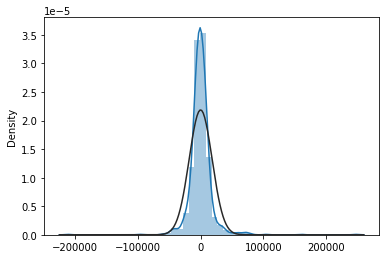

In [48]:
sns.distplot(model.resid, fit=stats.norm) 

##### Conclusion:

H1 is accepted at p-value = 0.05: the distribution of residuals is different from the normal distribution.

Indeed, there are some outliers, which is seen on the plot. The model does not really well fit the sample data

#### Multicollinearity

Multicollinearity can be checked to find any strong correlations between predictors

In [49]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
2,1.041597,Yearly bonus + stocks in EUR
0,1.145605,Annual brutto salary (without bonus and stocks...
11,1.261783,Gender_Diverse
3,1.461906,Years of experience in Germany
10,2.280436,Age
1,2.517547,Total years of experience
9,3.080780,Seniority level_other
4,5.236309,Seniority level_Head
5,8.445191,Seniority level_Junior
6,15.470151,Seniority level_Lead


##### Conclusion:

the most problematic variable are categorical variables (the biggest VIF). They can be removed in future analysis

### Heteroscedasticity

To check the well-fitness of the model, the heteroscedasticity can be evaluated. If the model is well-fitted, there should be no pattern to the residuals plotted against the fitted values.

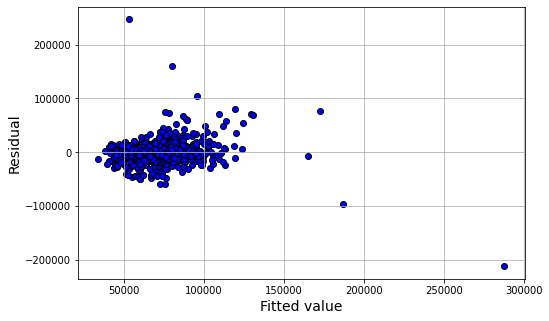

In [50]:
plt.figure(figsize=(8,5))
plt.scatter(x=model.fittedvalues, y=model.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

##### Conclustion: 

he model can be characterized to be both homoscedastic (for the first 100 000 fitted values) then heteroscedastic (for all the fitted values)

### Outliers and influential cases

Influential cases can be detected using DFFITS techniqe. Outliers can be detected by checking the standardized residuals of cases in the sample

In [51]:
influence = model.get_influence()
inf_sum = influence.summary_frame()
inf_sum

,dfb_const,dfb_Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,dfb_Total years of experience,dfb_Yearly bonus + stocks in EUR,dfb_Years of experience in Germany,dfb_Seniority level_Head,dfb_Seniority level_Junior,dfb_Seniority level_Lead,dfb_Seniority level_Middle,dfb_Seniority level_Senior,...,dfb_Age,dfb_Gender_Diverse,dfb_Gender_Male,dfb_Gender_Female,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2021 10:51:57,-0.000961,0.000590,-0.000501,0.001419,-0.000189,-0.000174,0.000050,-0.001604,0.000038,-0.000059,...,0.001837,0.000009,-0.000098,0.000001,0.000003,-0.078929,0.007172,-0.006709,-0.078897,-0.006706
01/01/2021 13:40:08,0.000232,-0.003475,0.007541,0.002152,-0.013628,0.000526,0.000669,0.005561,0.000432,0.000264,...,-0.000080,0.000553,-0.000107,-0.000301,0.000047,0.277330,0.009178,0.026691,0.277226,0.026681
01/12/2020 00:06:49,-0.002518,0.009486,-0.019048,-0.003565,0.010315,0.001118,-0.004087,0.000729,-0.002455,0.003470,...,0.004357,-0.000779,0.000465,0.010087,0.000207,0.598967,0.008560,0.055656,0.598812,0.055642
01/12/2020 00:16:18,0.000671,0.000184,0.002324,0.002231,0.006110,-0.000733,0.000136,-0.000631,-0.000085,-0.001804,...,-0.002303,0.000082,-0.000253,0.000360,0.000012,-0.262228,0.002674,-0.013577,-0.262129,-0.013572
01/12/2020 00:20:42,0.002997,-0.001501,0.003494,-0.010501,0.007604,0.000308,0.000225,0.000386,-0.002493,0.000157,...,-0.006037,0.000317,-0.000813,0.000539,0.000032,-0.295510,0.005386,-0.021747,-0.295401,-0.021739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30/11/2020 23:38:05,-0.000028,0.011602,0.017370,-0.005861,-0.012993,-0.000973,0.002224,-0.001115,0.006972,-0.000449,...,-0.007237,-0.000144,0.000762,-0.001840,0.000136,0.677336,0.004429,0.045179,0.677187,0.045169
30/12/2020 02:23:59,-0.001939,0.012273,0.023865,0.006848,-0.000722,-0.004294,0.004788,-0.013921,0.002483,-0.001638,...,-0.005434,0.001258,0.000190,-0.008483,0.000310,-0.547106,0.015294,-0.068183,-0.546950,-0.068163
30/12/2020 13:18:32,-0.000647,0.000158,-0.000039,0.001114,0.002690,-0.000383,0.000053,-0.000315,-0.000026,-0.000990,...,0.000986,0.000046,-0.000117,0.000192,0.000004,-0.146175,0.002626,-0.007501,-0.146117,-0.007498


#### Influent cases:

In [52]:
inf_sum['dffits'][(inf_sum['dffits']>1) | (inf_sum['dffits']<-1)].sort_values()

Timestamp
25/11/2020 18:02:06   -27.563862
25/11/2020 12:27:53    -8.562621
20/12/2020 00:30:53    -1.128327
26/11/2020 22:41:33     1.058014
05/01/2021 23:03:40     1.180292
24/11/2020 21:36:24     1.517755
25/11/2020 15:53:21     1.557621
25/11/2020 13:26:21     1.761252
Name: dffits, dtype: float64

#### Potential outliers

In [53]:
inf_sum['standard_resid'][(inf_sum['standard_resid']>3) | (inf_sum['standard_resid']<-3)].sort_values()

Timestamp
25/11/2020 18:02:06   -18.562803
25/11/2020 12:27:53    -7.750996
28/12/2020 22:24:47    -3.320307
30/11/2020 13:26:02    -3.255831
25/11/2020 09:00:23     3.063278
30/11/2020 13:17:39     3.193982
25/11/2020 10:58:13     3.326477
24/11/2020 12:14:03     3.328479
24/11/2020 11:28:14     3.345042
25/11/2020 13:12:26     3.674652
27/11/2020 13:02:41     3.889625
30/11/2020 14:36:32     3.919841
05/01/2021 23:03:40     3.953350
27/11/2020 13:02:57     4.014393
01/12/2020 00:32:37     4.062956
25/11/2020 15:53:21     4.469604
25/11/2020 13:16:43     4.485755
24/11/2020 21:36:24     5.866895
26/11/2020 22:41:33     8.759701
25/11/2020 13:26:21    13.534711
Name: standard_resid, dtype: float64

#### Conclusions:

The quantity of influetial cases and outliers is sufficiently low: both influential cases and outliers have a lot of rows (8 and 20)

# Final conclusion

The constructed linear model appeared to be statistically significant but explains only 44% variance of the worker's salary. Since this indicator is quite low, the model still has to be readjusted and refined. For instance, the statistically insignificant variables can be removed from the model. Another way is to remove all the outliers from the sample.

From my persepective, it is also better to try removing all variables which do not have a linear relationship with the dependent variable since they still cannot be well-fitted in the linear regression model.